# HiRes-CESM Interactive Dashboard Example

Images created by this package can be visualized through an interactive
dashboard using [Panelify](https://github.com/andersy005/panelify)


In [1]:
import pandas as pd
import panel as pn
import panelify

pn.extension()

---

## Accessing the Data (Plots)

The plots from this example are stored on the
[CGD webext machine](https://webext.cgd.ucar.edu/), specifically from
[this specific case](https://webext.cgd.ucar.edu/g.e22b05.G1850ECOIAF_JRA.TL319_g17.cocco.001/),
which we use as the path.


In [2]:
paths = (
    "https://webext.cgd.ucar.edu/g.e22.G1850ECO_JRA_HR.TL319_t13.004/",
    "https://webext.cgd.ucar.edu/g.e22.G1850ECO_JRA_HR.TL319_t13.003/",
)

### Read in the CSV File Containing Metadata

We use pandas to remotely read in the data, dropping the Unnamed column, and
merging the absolute path to the directory and the relative filepaths


In [3]:
df_list = []
for path in paths:
    df = pd.read_csv(f"{path}png_catalog.csv").drop(columns="Unnamed: 0")

    # Convert the relative filepaths to absolute filepaths
    df["absolute_filepath"] = path + df.filepath.astype(str)

    df_list.append(df)

# Merge the dataframes
df = pd.concat(df_list)

### Dealing with Relative vs. Absolute Paths

In the previous cell, we edited the filepaths... that is because the image filepaths are relative paths, but we would ideally like absolute paths. We make use of the dataframe path to assign the new absolute filepaths. An example is given below.


In [4]:
print("Original filepath: ", df.filepath.values[0])

# Convert the relative filepaths to absolute filepaths
df["filepath"] = path + df.filepath.astype(str)

print("New filepath ", df.filepath.values[0])

Original filepath:  histogram/CaCO3_FLUX_100m.0001-01-01_0001-12-31.png
New filepath  https://webext.cgd.ucar.edu/g.e22.G1850ECO_JRA_HR.TL319_t13.003/histogram/CaCO3_FLUX_100m.0001-01-01_0001-12-31.png


---

### Build the Dashboard

First, we check which types of plots are included in the analysis.


In [5]:
df.plot_type.unique()

array(['histogram', 'summary_map', 'time_series', 'trend_hist',
       'trend_map'], dtype=object)

Although there are five different plot types, we focus on the first three.

In [6]:
# Since we are using https, we leave this dictionary empty
storage_options = {}

# Create the timestep dashboard
summary_map = panelify.create_dashboard(
    keys=["casename", "varname", "date", "apply_log10"],
    df=df.loc[df.plot_type == "summary_map"],
    path_column="absolute_filepath",
    storage_options=storage_options,
    column_widget_types={"date": "discrete_slider"},
)

# Create the timeseries dashboard
time_series = panelify.create_dashboard(
    keys=[
        "casename",
        "varname",
    ],
    df=df.loc[df.plot_type == "time_series"],
    path_column="absolute_filepath",
    storage_options=storage_options,
)

# Create the histogram dashboard
histogram = panelify.create_dashboard(
    keys=["casename", "varname", "time_period", "apply_log10"],
    df=df.loc[df.plot_type == "histogram"],
    path_column="absolute_filepath",
    storage_options=storage_options,
    column_widget_types={"time_period": "discrete_slider"},
)

# Bring the various dashboard components into a single canvas
canvas = panelify.Canvas(
    {
        "Summary Map": summary_map.view,
        "Time Series": time_series.view,
        "Histogram": histogram.view,
    }
)

### Run the Dashboard Inline

Now that we have built the dashboard, we run it within the notebook.


Row
    [0] Column(background='#659dbd')
        [0] Markdown(str)
        [1] Row
            [0] Spacer(width=10)
            [1] Markdown(str)
            [2] Spacer(width=10)
            [3] Markdown(str)
    [1] Row
        [0] Tabs
            [0] ParamMethod(method, name='Summary Map')
            [1] ParamMethod(method, name='Time Series')
            [2] ParamMethod(method, name='Histogram')
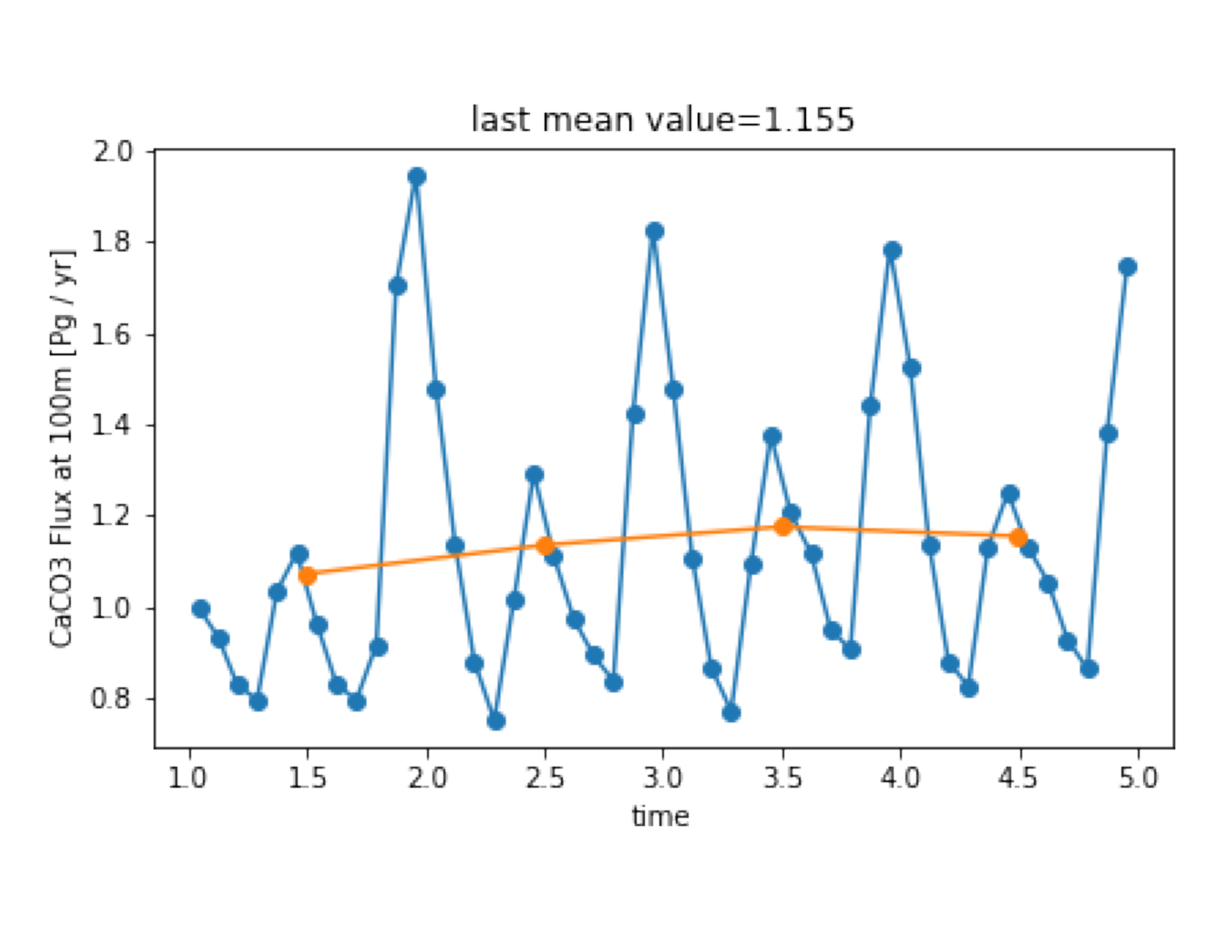
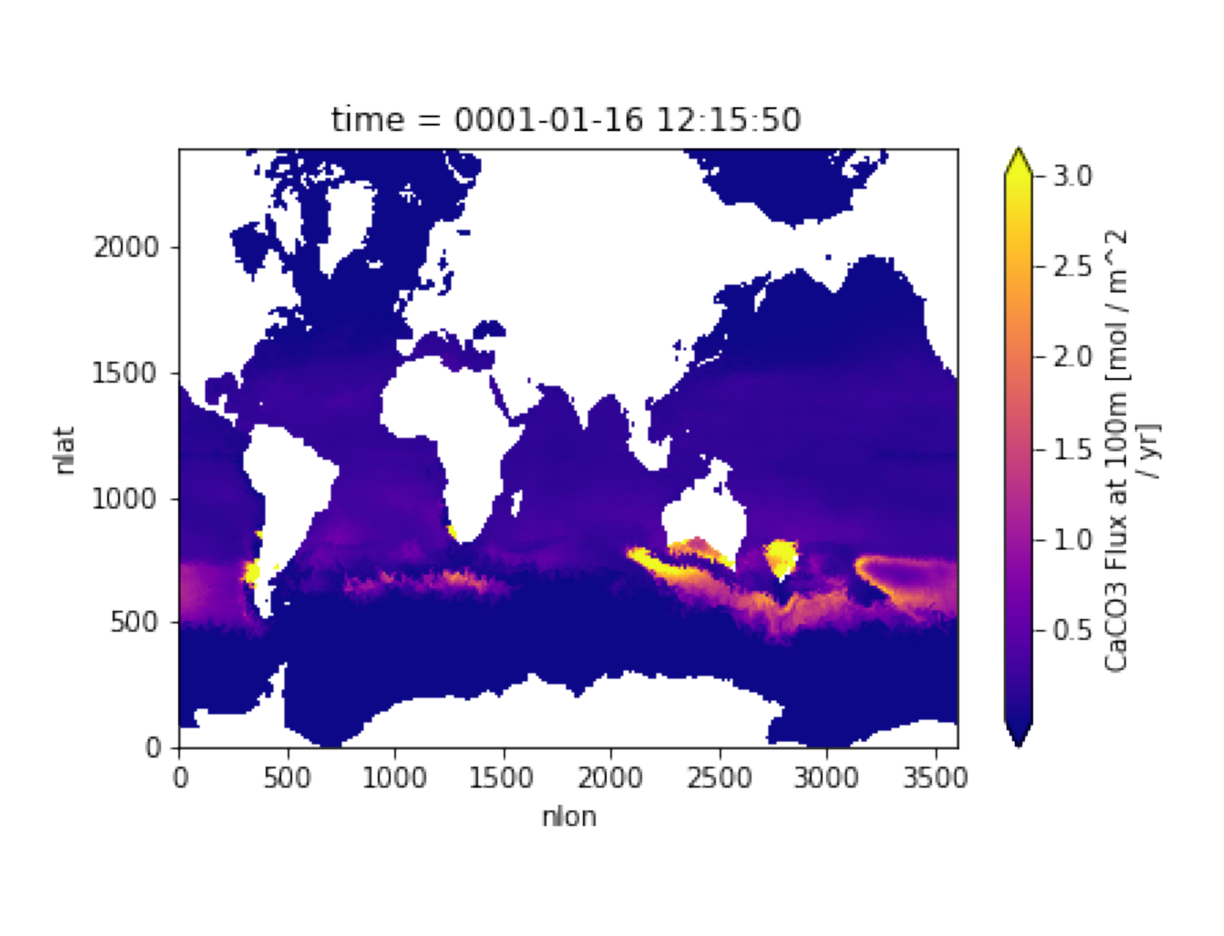
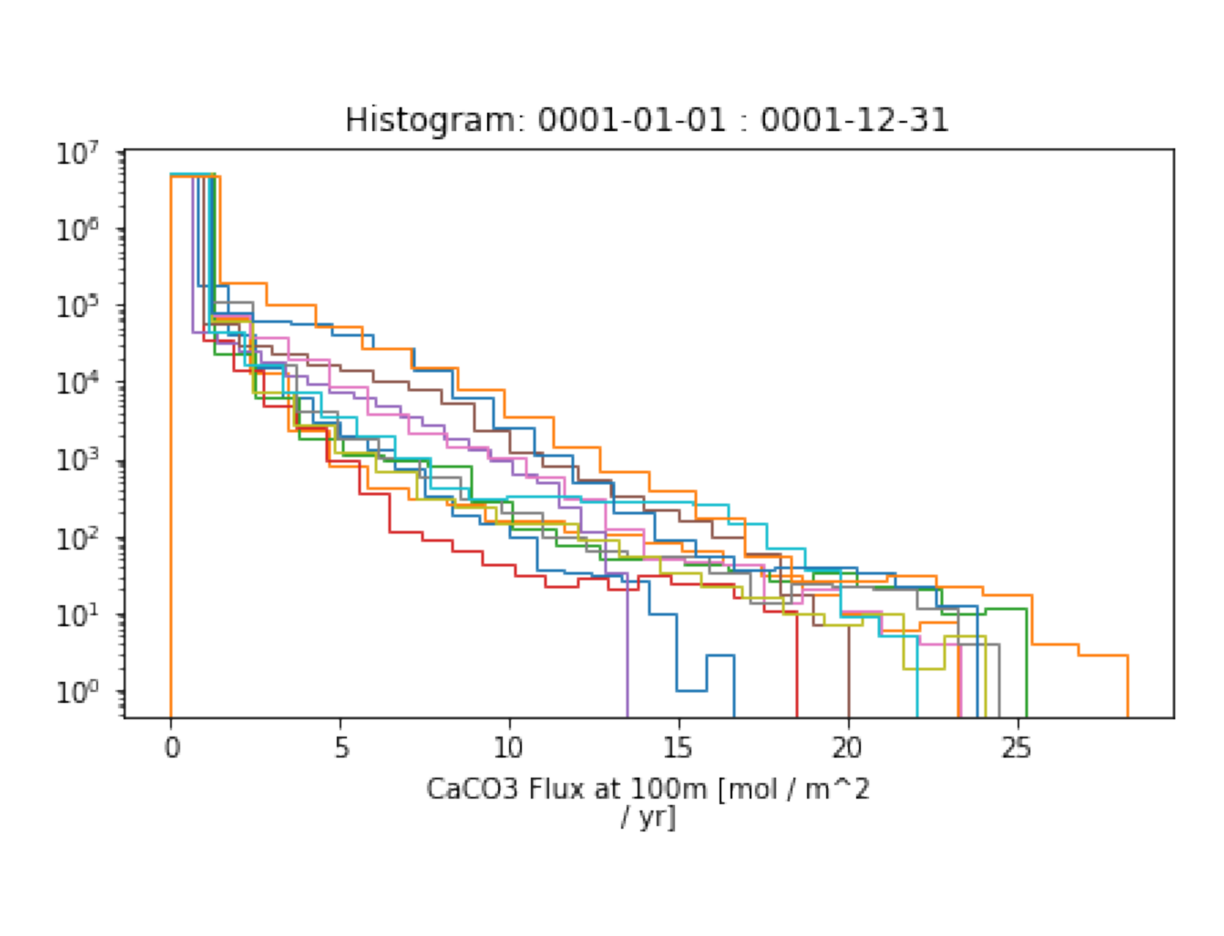

In [7]:
hv_logo = '<a href="https://holoviz.org"><img src="https://holoviz.org/assets/holoviz-logo-stacked.svg" width=80></a>'
thumbnail = '<a href="https://github.com/marbl-ecosys/"><img src="https://raw.githubusercontent.com/NCAR/cesm-lens-aws/master/thumbnail.png" width=80 height=80></a>'
menu_background = "#659dbd"
menu_text = "<div><p>0.1 degree POP / CICE run with ocean BGC</p><br><br><p><a href='https://github.com/marbl-ecosys/HiRes-CESM-analysis'>HiRes-CESM analysis repo</a></p><p><a href='https://github.com/andersy005/HiRes-CESM-dashboard'>HiRes-CESM dashboard repo</a></p></div><br><br>"
menu = pn.Column(
    menu_text,
    pn.Row(
        pn.Spacer(width=10),
        pn.Pane(thumbnail),
        pn.Spacer(width=10),
        pn.Pane(hv_logo),
    ),
    background=menu_background,
)

dashboard = pn.Row(menu, canvas.show())
dashboard.servable("HiRes-CESM Diagnostics Dashboard")